# Codifica dell'individuo

Nel rappresentare una soluzione bisogna usare una struttura a grafo, più precisamente uno spanning tree con il costo globalmente minore e che rispetti il vincolo di capacità.

## Descrizione strutture dati

Per fare ciò uso l'oggetto `individual` che rappresenta un individuo della popolazione. Ogni oggetto contiene al suo interno:
- __tree__ che è la lista di tuple che implementa l'albero
- __fitness__ che rappresenta la fitness della soluzione
- __optim_type__ flag che indica se sto minimizzando o massimizzando
- __genotype__ lista di interi a lunghezza variabile che rappresenta la rete

## Aspetti salienti
La scopo principale dell'oggetto `individual` è quello di rappresentarmi la rete in modo maneggiabile. Per farlo creo la rete e la memorizzo nell'attributo _genotype_, così che
ogni individuo sia (all'inizio) una rete completa e poi a fine elaborazione un grafo (sperabilmente) soluzione.
Ogni link possibile gli viene assegnato un intero che segnala la presenza dell'arco. Non solo questo intero segnala la presenza dell'arco ma rappresenta anche il
peso dell'arco stesso nella lista _ordinata_. Ogni lista può definire in modo univoco quali collegamenti esistono e quali no.

Mi appresto a dimostrare la seguente proposizione: la rappresentazione genoma <-> grafo è biunivoca e corretta.
Questa proposizione implica che è possibile partire da una rappresentazione (compatibile con le librerie usate) sotto forma di grafo, ed arrivare ad una
rappresentazione sotto forma di genoma (cioè lista di interi a lunghezza variabile) _e_ _viceversa_.
### dimostrazione

In [1]:
import numpy as np
from CMST_package.individual import Individual
from CMST_package.population_generator import draw_graph
import networkx as nx

Costruisco il grafo assegnando come peso (ed etichetta identificativa) la coppia nodo-sorgente/nodo-destinatario dunque $ C_{ij} = sorgente|destinazione $

In [2]:
G = nx.complete_graph(6)
G[0][1]['weight'] = "01"
G[0][2]['weight'] = "02"
G[0][3]['weight'] = "03"
G[0][4]['weight'] = "04"
G[0][5]['weight'] = "05"
G[1][2]['weight'] = "12"
G[1][3]['weight'] = "13"
G[1][4]['weight'] = "14"
G[1][5]['weight'] = "15"
G[2][3]['weight'] = "23"
G[2][4]['weight'] = "24"
G[2][5]['weight'] = "25"
G[3][4]['weight'] = "34"
G[3][5]['weight'] = "35"
G[4][5]['weight'] = "45"

Creo e visualizzo il grafo full mesh con $ n*(n-1) $ archi, dove $ n $ è il numero di nodi nella rete, in questo caso 6. per cambiare numero nodi, modificare la sezione precedente.

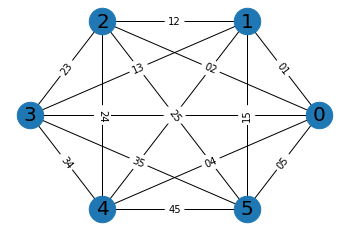

<Figure size 864x864 with 0 Axes>

In [3]:
draw_graph(G, 0)

A questo punto genero la lista di adiacenza in modo da facilitare la conversione in lista normale. Segue poi la visualizzazione della lista di adiacenza.

In [4]:
print("Matrice di adiacenza: ")
adj_list = nx.generate_adjlist(G)

string = ""
i = 0
for arc in adj_list:
    print("Il nodo {0} è connesso con i seguenti nodi: \t{1}".format(i, arc))
    string += arc
    i += 1

Matrice di adiacenza: 
Il nodo 0 è connesso con i seguenti nodi: 	0 1 2 3 4 5
Il nodo 1 è connesso con i seguenti nodi: 	1 2 3 4 5
Il nodo 2 è connesso con i seguenti nodi: 	2 3 4 5
Il nodo 3 è connesso con i seguenti nodi: 	3 4 5
Il nodo 4 è connesso con i seguenti nodi: 	4 5
Il nodo 5 è connesso con i seguenti nodi: 	5


Da notare come la matrice sia triangolare, questo poiché il grafo è _non_ orientato e quindi la lista di adiacenza stampata in forma matriciale non riporta gli
archi in verso opposto. Attenzione alla prima colonna, quelli sono tutti collegamenti loopback, nella matrice di adiacenza sarebbero sulla diagonale. In questo caso
non vengono considerati e in seguito verranno scartati.

Ora proseguo con il mostrare come convertire questa rappresentazione lista-adiacenza in genoma in step successivi:
    1. Reshaping della lista di adiacenza in un vettore 1-d

In [5]:
lista = [item for item in string if item != ' ']
print("La lista srotolata in formato simil-genoma è: \n\t{0}".format(lista))

La lista srotolata in formato simil-genoma è: 
	['0', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '2', '3', '4', '5', '3', '4', '5', '4', '5', '5']


    2. A questo punto creo un nuovo individuo di prova e gli assegno la lista di adiacenza srotolata come genoma.

In [6]:
ind = Individual(size=10, min=1, iter_range=256)
ind.genotype = lista
print(ind.genotype)

['0', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '2', '3', '4', '5', '3', '4', '5', '4', '5', '5']


Qui vediamo la correttezza dell'operazione in un verso, da grafo l'ho trasformato in genoma.

Adesso il viceversa. Partendo dallo steso individuo voglio, partendo dal suo genoma, ottenere il grafo originario:

    1. Faccio il reshaping del genoma in lista di adiacenza (in forma matriciale), attenzione l'etichetta dell'arco è composta da _sorgente|destinazione|index_

In [7]:
matrix = np.array(ind.reshape2matrix(NUM_NODES=6))
n = matrix.shape[0]
matrix[range(n), range(n)] = "0"
print(matrix)

[['0' '104' '204' '305' '402' '505']
 ['014' '0' '215' '311' '413' '512']
 ['024' '125' '0' '322' '424' '523']
 ['035' '131' '232' '0' '435' '534']
 ['042' '143' '244' '345' '0' '545']
 ['055' '152' '253' '354' '455' '0']]


    2. Creo una nuova matrice dei risultati eliminando la diagonale (in realtà la pongo a zero per problemi di incompatibilità fra librerie)

In [8]:
shape = matrix.shape
result = np.zeros(shape, dtype=int)
for x in range(0, shape[0]):
    for y in range(0, shape[1]):
        result[x, y] = str(matrix[x, y])[0:2]
print(result)

[[ 0 10 20 30 40 50]
 [ 1  0 21 31 41 51]
 [ 2 12  0 32 42 52]
 [ 3 13 23  0 43 53]
 [ 4 14 24 34  0 54]
 [ 5 15 25 35 45  0]]


    3. Visualizzazione del grafo a partire dalla lista di adiacenza, mi aspetto sia lo stesso grafo visualizzato all'inizio.

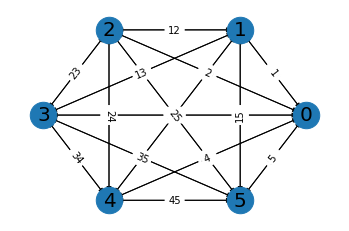

<Figure size 864x864 with 0 Axes>

In [9]:
g = nx.from_numpy_matrix(result, create_using=nx.DiGraph)
draw_graph(g, layout=0)

A meno di alcuni difetti dovuti alla gestione Python delle stringhe, i grafi sono gli stessi. In pratica `01` non è possibile visualizzarlo poiché diventa `1` dato che viene trattato
come un intero e non un'etichetta.

## Reshaping function
Per riarrotolare il genoma dell'individuo devo tenere conto del fatto che il genoma è una versione undimensionale della matrice di adiacenza e che la matrice dei costi è una versione
bidimensionale della lista di adiacenza. Sono entrambe rappresentazioni dei costi ma con forme (dimensioni) diverse. La sezione di codice che esegue l'operazione di riarrotolamento
è la seguente:

```python
   L = max(row, col)                            # ['0', '1', '2', '3', '4', '5', '1', '2', '3', '4'
   S = min(row, col)                            # 1° step seleziono 0 poi con l'indice L scorro verso
   index = L * (L - 1) / 2                      # destra, ottenendo (0, 1) -> (0,2) e così via
   index += S - 1                               # uso l'indice _index_ come terza cifra per far capire
   index -= L                                   # a che passaggio ero quando ho ricostruito quell'arco
   matrix[col][row] = genome[row]               # sommo (o concateno) i singoli geni del genotipo.
   matrix[col][row] += genome[col]              # nella diagonale avrò sys.maxsize, cioè un peso infinito
   matrix[col][row] += genome[int(index)]       # poiché non voglio archi loopback
   ```







